readings:
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/

In [1]:
# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# data
test = pd.read_csv("titanic/test.csv")
train = pd.read_csv("titanic/train.csv")

In [2]:
total = train.isnull().sum().sort_values(ascending=False)
display(train.shape, test.shape)

(891, 12)

(418, 11)

In [3]:
total

Cabin          687
Age            177
Embarked         2
Fare             0
Ticket           0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
Survived         0
PassengerId      0
dtype: int64

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
# we have to get rid of the objects somehow:
train[['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']].head()

# Name is unique; Cabin hast to many Nans, Ticket is somehow unique too
train = train.drop(['Name', 'Ticket', 'Cabin'], axis = 1)
test = test.drop(['Name', 'Ticket', 'Cabin'], axis = 1)

In [6]:
unique_embarked = set(train.Embarked.unique()).union(test.Embarked.unique())
embarked = dict(zip(unique_embarked, list(range(len(unique_embarked)))))
unique_sex = set(train.Sex.unique()).union(test.Sex.unique())
sex = dict(zip(unique_sex, list(range(len(unique_sex)))))

data = [train, test]
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(embarked)
    dataset['Sex'] = dataset['Sex'].map(sex)
    dataset['Age'] = dataset['Age'].fillna(dataset['Age'].mode().values[0])    

In [7]:
survived = train['Survived']
train = train.drop('Survived', axis=1)
rf = RandomForestClassifier()
rf.fit(train, survived)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

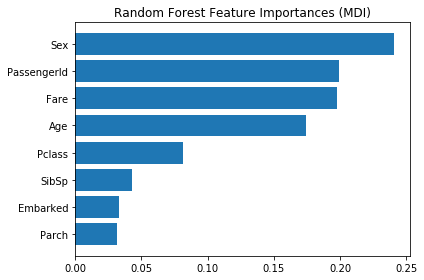

In [8]:
tree_feature_importances = rf.feature_importances_
feature_names = train.columns
sorted_idx = tree_feature_importances.argsort()
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

In [9]:
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
k=5

encoder = CatBoostEncoder(cols = 'PassengerId')
folds = StratifiedKFold(n_splits = k, shuffle=True, random_state=1234)

test_PassId = np.zeros(test.shape[0])
train_trg = train.copy()
test_trg = test.copy()
for train_fold_idx, test_fold_idx in folds.split(train, survived):
    _ = encoder.fit_transform(train.loc[train_fold_idx], survived[train_fold_idx])
    train_trg.loc[test_fold_idx, :] = encoder.transform(train.loc[test_fold_idx])
    test_PassId += (encoder.transform(test)['PassengerId']/k)
test_trg['PassengerId'] = test_PassId

In [10]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,0,34.5,0,0,7.8292,2
1,893,3,1,47.0,1,0,7.0000,3
2,894,2,0,62.0,0,0,9.6875,2
3,895,3,0,27.0,0,0,8.6625,3
4,896,3,1,22.0,1,1,12.2875,3


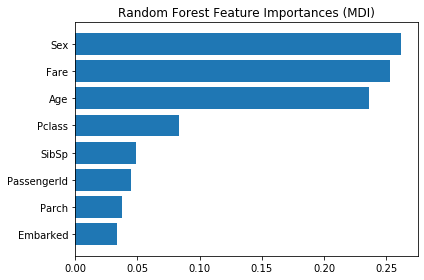

In [11]:
rf = RandomForestClassifier()
rf.fit(train_trg, survived)
tree_feature_importances = rf.feature_importances_
feature_names = train.columns
sorted_idx = tree_feature_importances.argsort()
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

In [12]:
encoder = OneHotEncoder(cols = 'Age')
train_oh = encoder.fit_transform(train_trg)
test_oh = encoder.transform(test_trg)

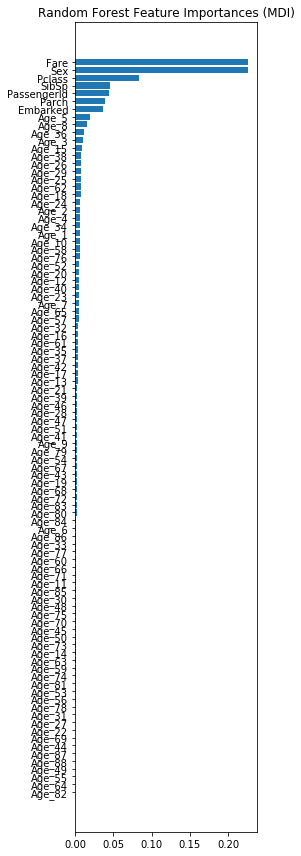

In [13]:
rf = RandomForestClassifier()
rf.fit(train_oh, survived)
tree_feature_importances = rf.feature_importances_
feature_names = train_oh.columns
sorted_idx = tree_feature_importances.argsort()
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(4, 12))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

# Permutation variable importance

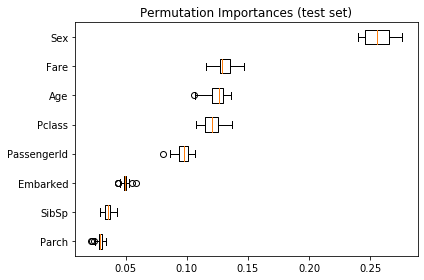

In [14]:
from sklearn.inspection import permutation_importance

rf_model = RandomForestClassifier()
rf_model.fit(train, survived)
result = permutation_importance(rf_model, train, survived,
        n_repeats=30,
        random_state=0)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=train.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

# Gini-coefficient (gini impurity) for splitting variables

\begin{equation*}
\text{gini}=1-\sum_i^n P_i^2 
\end{equation*}
where $i$ is the class index;
The gini impurity measueres the purity of a node. If all elements within one node fall in one class, $P_i=1$ and the impurity is at its minimum.\\
Gini impurity favours splitting repeatedly on continuous variables and thus cutting out regions of very low impurity. The continuous variable itself might even contain no real information at all (PassengerId).

# experiment

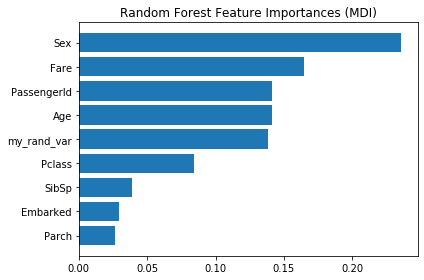

In [15]:
# simple random variable not all values unique (vs. PassengerId)

from numpy.random import randint
train_rand = train.copy()
train_rand['my_rand_var'] = randint(0, train.shape[0], train.shape[0])
rf_rand = RandomForestClassifier()
rf_rand.fit(train_rand, survived)
tree_feature_importances = rf_rand.feature_importances_
feature_names = train_rand.columns
sorted_idx = tree_feature_importances.argsort()
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

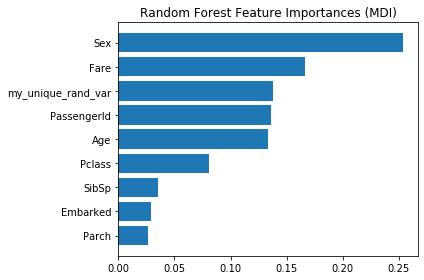

In [17]:
# simple random variable not all values unique (vs. PassengerId)

from numpy.random import choice
train_rand_all_unique = train.copy()
train_rand_all_unique['my_unique_rand_var'] = choice(np.arange(train.shape[0]), train.shape[0], replace=False)
rf_rand_all_unique = RandomForestClassifier()
rf_rand_all_unique.fit(train_rand_all_unique, survived)
tree_feature_importances = rf_rand_all_unique.feature_importances_
feature_names = train_rand_all_unique.columns
sorted_idx = tree_feature_importances.argsort()
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()